## Building your Recurrent Neural Network - Step by Step  
deep-learning.ai -- sequence models -- week1 assignment  以下将利用Numpy一步步实现一个RNN模型

**Notation**:

* Superscript $[l]$ denotes an object associated with the $l^{th}$ layer.  

  * Example: $a^{[4]}$ is the $4^{th}$ layer activation. $W^{[5]}$ and $b^{[5]}$ are the $5^{th}$ layer parameters.    
  
* Superscript $(i)$ denotes an object associated with the $i^{th}$ example.  

  * Example: $x^{(i)}$ is the $i^{th}$ training example input.  

* Superscript $\langle t \rangle$ denotes an object at the $t^{th}$ time-step.  

  * Example: $x^{\langle t \rangle}$ is the input x at the $t^{th}$ time-step. $x^{(i)\langle t \rangle}$ is the input at the $t^{th}$ timestep of example $i$.  

* Lowerscript $i$ denotes the $i^{th}$ entry of a vector.  

  * Example: $a^{[l]}_i$ denotes the $i^{th}$ entry of the activations in layer $l$.  

In [1]:
import numpy as np
from rnn_utils import *
# rnn_utils 是自定义模块，包含用numpy定义的softmax函数、sigmoid函数、adam方法

接下来将利用基础RNN模型形成音乐。用到的RNN模型是一个多对多且$T_x=T_y$的模型 

## 1 - 基础RNN模型的前向传播  

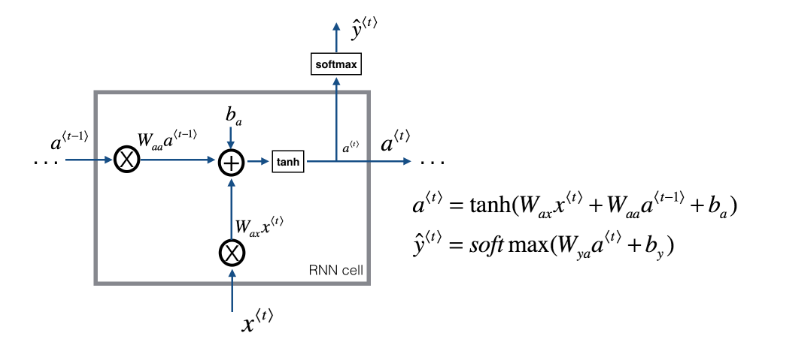

**Instructions**:  

  1.Compute the hidden state with tanh activation: $a^{\langle t \rangle} = \tanh(W_{aa} a^{\langle t-1 \rangle} + W_{ax} x^{\langle t \rangle} + b_a)$.  
  
  2.Using your new hidden state $a^{\langle t \rangle}$, compute the prediction $\hat{y}^{\langle t \rangle} = softmax(W_{ya} a^{\langle t \rangle} + b_y)$. We provided you a function: softmax.  
  
  3.Store $(a^{\langle t \rangle}, a^{\langle t-1 \rangle}, x^{\langle t \rangle}, parameters)$ in cache

  4.Return $a^{\langle t \rangle}$ , $y^{\langle t \rangle}$ and cache  

We will vectorize over $m$ examples. Thus, $x^{\langle t \rangle}$ will have dimension $(n_x,m)$, and $a^{\langle t \rangle}$ will have dimension $(n_a,m)$.

In [2]:
def rnn_cell_forward(xt, a_prev, parameters):
    """
    完成一个RNN-cell的前向传播过程

    Arguments:
    xt -- t时刻的输入，类型为np.array，size 为(n_x, m).
    a_prev -- t-1 时刻隐藏层的输出,类型为np.array，size 为(n_a, m)
    parameters -- 以字典形式存储如下参数:
                        Wax -- Weight matrix multiplying the input, numpy array of shape (n_a, n_x)
                        Waa -- Weight matrix multiplying the hidden state, numpy array of shape (n_a, n_a)
                        Wya -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        ba --  Bias, numpy array of shape (n_a, 1)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
    Returns:
    a_next -- t 时刻隐藏层的输出,类型为np.array，size 为 (n_a, m)
    yt_pred -- t 时刻的估计值,类型为np.array，size 为 (n_y, m)
    cache -- 需要做反向传播的参数元组, 包含 (a_next, a_prev, xt, parameters)
    """ 
    # Retrieve parameters from parameters
    Wax = parameters['Wax']
    Waa = parameters['Waa']
    Wya = parameters['Wya']
    ba = parameters['ba']
    by = parameters['by']
     
    # compute next activation state using the formula given above
    a_next = np.tanh(np.dot(Waa, a_prev) + np.dot(Wax, xt) + ba)
    # compute output of the current cell using the formula given above 
    yt_pred = softmax(np.dot(Wya, a_next) + by)
    # store values you need for backward propagation in cache
    cache = (a_next, a_prev, xt, parameters)
    
    return a_next, yt_pred, cache

In [3]:
np.random.seed(1)
xt = np.random.randn(3,10) # xt.shape(nx,mx)
a_prev = np.random.randn(5,10)# a.shape(na,mx)
Waa = np.random.randn(5,5) # waa.shape(na,na)
Wax = np.random.randn(5,3) # wax.shape(na,nx)
Wya = np.random.randn(2,5) # wya.shape(ny,na)
ba = np.random.randn(5,1) # ba.shape(na,1)
by = np.random.randn(2,1) # by.shape(ny,1)

parameters = {'Waa':Waa,'Wax':Wax,'Wya':Wya,
             'ba':ba,'by':by}

a_next, yt_pred, cache = rnn_cell_forward(xt, a_prev, parameters)

print('a_next[4] = ',a_next[4])
print('a_next.shape = ',a_next.shape)
print("yt_pred[1] =", yt_pred[1])
print("yt_pred.shape = ", yt_pred.shape)

a_next[4] =  [ 0.59584544  0.18141802  0.61311866  0.99808218  0.85016201  0.99980978
 -0.18887155  0.99815551  0.6531151   0.82872037]
a_next.shape =  (5, 10)
yt_pred[1] = [0.9888161  0.01682021 0.21140899 0.36817467 0.98988387 0.88945212
 0.36920224 0.9966312  0.9982559  0.17746526]
yt_pred.shape =  (2, 10)


## 1.2 - RNN 前向传播的传递  

比如输入有10个时间步，则依次将单元RNN相连，每个单元的输入来自上层的$a^{<t−1>}$和本层的$x^{<t>}$，输出$a^{<t>}$和$\hat y^{<t>}$。

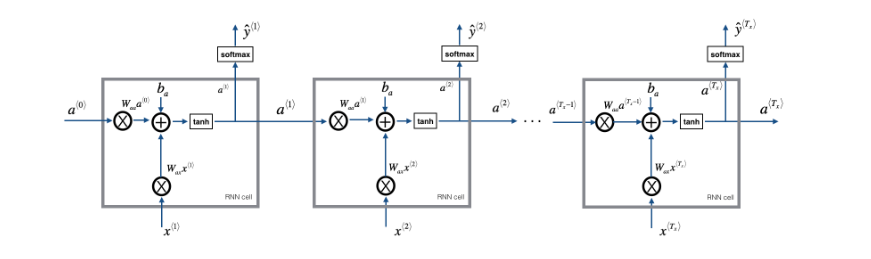

**练习：实现上图描述的RNN 的前向传播**  
* 1.创建一个0值向量a, 用来存储RNN计算的所有隐藏状态  
* 2.初始化”next”隐藏层状态$a_0$   
* 3.循环每个时间步，循环变量为t:   
   * 3.1 执行rnn_cell_forward，更新”next”隐藏状态和cache 
   * 3.2 存储”next”隐藏状态到a($t^{th}$ 位置)  
   * 3.3 存储预测输出y  
   * 3.4 将cache加到列表 caches 中  
* 4.返回a, y 和caches  

In [4]:
# GRADED FUNCTION: rnn_forward
def rnn_forward(x, a0, parameters):
    """
    实现RNN的前向传播过程
    
    Arguments:
    x -- Input data for every time-step, of shape (n_x, m, T_x).
    a0 -- Initial hidden state, of shape (n_a, m)
    parameters -- python dictionary containing:
                        Waa -- Weight matrix multiplying the hidden state, numpy array of shape (n_a, n_a)
                        Wax -- Weight matrix multiplying the input, numpy array of shape (n_a, n_x)
                        Wya -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        ba --  Bias numpy array of shape (n_a, 1)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)

    Returns:
    a -- Hidden states for every time-step, numpy array of shape (n_a, m, T_x)
    y_pred -- Predictions for every time-step, numpy array of shape (n_y, m, T_x)
    caches -- tuple of values needed for the backward pass, contains (list of caches, x)
    """  
    # Initialize "caches" which will contain the list of all caches
    caches =[]
    
    # Retrieve dimensions from shapes of x and Wy
    n_x, m_x, t_x = x.shape
    n_y, n_a = parameters['Wya'].shape
    
    # initialize "a" and "y" with zeros (≈2 lines)
    a = np.zeros((n_a, m_x, t_x))
    y_pred = np.zeros((n_y, m_x, t_x))
    
    # Initialize a_next (≈1 line)
    a_next = a0
    
    # loop over all time-steps
    for t in range(t_x):
        # Update next hidden state, compute the prediction, get the cache (≈1 line)
        a_next, yt_pred, cache = rnn_cell_forward(x[:,:,t], a_next, parameters)
        
        # Save the value of the new "next" hidden state in a (≈1 line)
        a[:,:,t] = a_next
        
        # Save the value of the prediction in y (≈1 line)
        y_pred[:,:,t] = yt_pred
        
        # Append "cache" to "caches" (≈1 line)
        caches.append(cache)
    # store values needed for backward propagation in cache
    caches = (caches, x) 
    
    return a, y_pred, caches

In [5]:
np.random.seed(1)
x = np.random.randn(3,10,4)# xt.shape(nx,mx,tx)
a0 = np.random.randn(5,10) # a.shape(na,mx)
Waa = np.random.randn(5,5) # waa.shape(na,na)
Wax = np.random.randn(5,3) # wax.shape(na,nx)
Wya = np.random.randn(2,5) # wya.shape(ny,na)
ba = np.random.randn(5,1) # ba.shape(na,1)
by = np.random.randn(2,1) # by.shape(ny,1)
parameters = {"Waa": Waa, "Wax": Wax, "Wya": Wya, "ba": ba, "by": by}

a, y_pred, caches = rnn_forward(x, a0, parameters)
print("a[4][1] = ", a[4][1])
print("a.shape = ", a.shape)
print("y_pred[1][3] =", y_pred[1][3])
print("y_pred.shape = ", y_pred.shape)
print("caches[1][1][3] =", caches[1][1][3])
print("len(caches) = ", len(caches))

a[4][1] =  [-0.99999375  0.77911235 -0.99861469 -0.99833267]
a.shape =  (5, 10, 4)
y_pred[1][3] = [0.79560373 0.86224861 0.11118257 0.81515947]
y_pred.shape =  (2, 10, 4)
caches[1][1][3] = [-1.1425182  -0.34934272 -0.20889423  0.58662319]
len(caches) =  2


恭喜！你已经建立了一个循环神经网络的前向传播函数。在一些情况下你的程序运行良好。但是存在梯度消失的问题。如果能在近距离评估每个$\hat y$的话程序将会执行的更好。

## 2 - Backpropagation in recurrent neural networks  
在递归神经网络中，可以根据损失函数的梯度来更新参数  
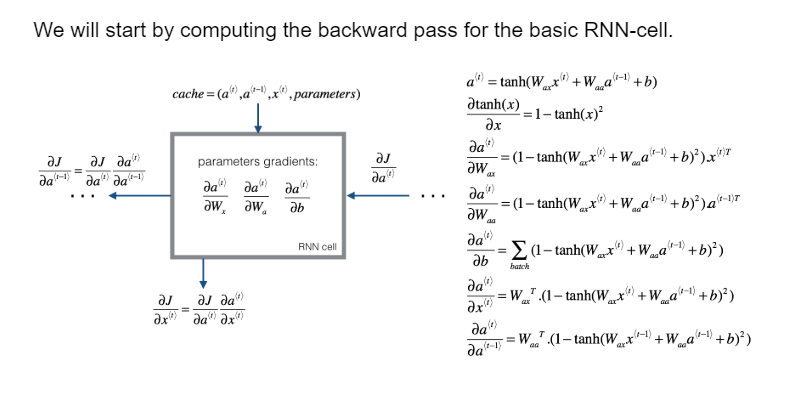

In [10]:
def rnn_cell_backward(da_next, cache):
    """
    在 RNN-cell上实现反向传播 (single time-step).

    Arguments:
    da_next -- Gradient of loss with respect to next hidden state
    cache -- python dictionary containing useful values (output of rnn_cell_forward())

    Returns:
    gradients -- python dictionary containing:
                        dx -- Gradients of input data, of shape (n_x, m)
                        da_prev -- Gradients of previous hidden state, of shape (n_a, m)
                        dWax -- Gradients of input-to-hidden weights, of shape (n_a, n_x)
                        dWaa -- Gradients of hidden-to-hidden weights, of shape (n_a, n_a)
                        dba -- Gradients of bias vector, of shape (n_a, 1)
    """
    # Retrieve values from cache
    (a_next, a_prev, xt, parameters) = cache
    
    # Retrieve values from parameters
    Wax = parameters["Wax"]
    Waa = parameters["Waa"]
    Wya = parameters["Wya"]
    ba = parameters["ba"]
    by = parameters["by"]
    
    # compute the gradient of tanh with respect to a_next (≈1 line)
    dtanh = (1-a_next**2) * da_next ## 计算损失函数关于tanh的偏导=loss关于激活at的偏导*at关于tanh的偏导
    
    # compute the gradient of the loss with respect to Wax (≈2 lines)
    dxt = np.dot(Wax.T, dtanh)
    dWax = np.dot(dtanh,xt.T)
    
    # compute the gradient with respect to Waa (≈2 lines)
    da_prev = np.dot(Waa.T, dtanh)
    dWaa = np.dot(dtanh, a_prev.T)
    
    # compute the gradient with respect to b (≈1 line)
    dba = np.sum(dtanh, 1, keepdims=True) #keepdims 保持维度,axis=1计算每行向量的和

    # Store the gradients in a python dictionary
    gradients = {"dxt": dxt, "da_prev": da_prev, "dWax": dWax, "dWaa": dWaa, "dba": dba}
    
    return gradients

In [12]:
np.random.seed(1)
xt = np.random.randn(3,10)
a_prev = np.random.randn(5,10)
Wax = np.random.randn(5,3)
Waa = np.random.randn(5,5)
Wya = np.random.randn(2,5)
b = np.random.randn(5,1)
by = np.random.randn(2,1)
parameters = {"Wax": Wax, "Waa": Waa, "Wya": Wya, "ba": ba, "by": by}

a_next, yt, cache = rnn_cell_forward(xt, a_prev, parameters)

da_next = np.random.randn(5,10)
gradients = rnn_cell_backward(da_next, cache)
print("gradients[\"dxt\"][1][2] =", gradients["dxt"][1][2])
print("gradients[\"dxt\"].shape =", gradients["dxt"].shape)
print("gradients[\"da_prev\"][2][3] =", gradients["da_prev"][2][3])
print("gradients[\"da_prev\"].shape =", gradients["da_prev"].shape)
print("gradients[\"dWax\"][3][1] =", gradients["dWax"][3][1])
print("gradients[\"dWax\"].shape =", gradients["dWax"].shape)
print("gradients[\"dWaa\"][1][2] =", gradients["dWaa"][1][2])
print("gradients[\"dWaa\"].shape =", gradients["dWaa"].shape)
print("gradients[\"dba\"][4] =", gradients["dba"][4])
print("gradients[\"dba\"].shape =", gradients["dba"].shape)

gradients["dxt"][1][2] = -0.4605641030588796
gradients["dxt"].shape = (3, 10)
gradients["da_prev"][2][3] = 0.08429686538067718
gradients["da_prev"].shape = (5, 10)
gradients["dWax"][3][1] = 0.3930818739219304
gradients["dWax"].shape = (5, 3)
gradients["dWaa"][1][2] = -0.2848395578696067
gradients["dWaa"].shape = (5, 5)
gradients["dba"][4] = [0.80517166]
gradients["dba"].shape = (5, 1)


进一步地实现整个循环神经网络的反向传播

In [49]:
def rnn_backward(da, caches):
    """
    Implement the backward pass for a RNN over an entire sequence of input data.

    Arguments:
    da -- Upstream gradients of all hidden states, of shape (n_a, m, T_x)
    caches -- tuple containing information from the forward pass (rnn_forward)
    
    Returns:
    gradients -- python dictionary containing:
                        dx -- Gradient w.r.t. the input data, numpy-array of shape (n_x, m, T_x)
                        da0 -- Gradient w.r.t the initial hidden state, numpy-array of shape (n_a, m)
                        dWax -- Gradient w.r.t the input's weight matrix, numpy-array of shape (n_a, n_x)
                        dWaa -- Gradient w.r.t the hidden state's weight matrix, numpy-arrayof shape (n_a, n_a)
                        dba -- Gradient w.r.t the bias, of shape (n_a, 1)
    """
        
    ### START CODE HERE ###
    
    # Retrieve values from the first cache (t=1) of caches (≈2 lines)
    (caches, x) = caches
    (a1, a0, x1, parameters) = caches[0]
    
    # Retrieve dimensions from da's and x1's shapes (≈2 lines)
    n_a, m, T_x = da.shape
    n_x, m = x1.shape
    
    # initialize the gradients with the right sizes (≈6 lines)
    dx = np.zeros((n_x, m, T_x))
    dWax = np.zeros((n_a, n_x))
    dWaa = np.zeros((n_a, n_a))
    dba = np.zeros((n_a, 1))
    da0 = np.zeros((n_a, m))
    da_prevt = np.zeros((n_a, m))
    
    # Loop through all the time steps
    for t in reversed(range(T_x)):
        # Compute gradients at time step t. Choose wisely the "da_next" and the "cache" to use in the backward propagation step. (≈1 line)
        gradients = rnn_cell_backward(da[:,:, t] + da_prevt, caches[t])
        # Retrieve derivatives from gradients (≈ 1 line)
        dxt, da_prevt, dWaxt, dWaat, dbat = gradients["dxt"], gradients["da_prev"], gradients["dWax"], gradients["dWaa"], gradients["dba"]
        # Increment global derivatives w.r.t parameters by adding their derivative at time-step t (≈4 lines)
        dx[:, :, t] = dxt
        dWax += dWaxt
        dWaa += dWaat
        dba += dbat
        
    # Set da0 to the gradient of a which has been backpropagated through all time-steps (≈1 line) 
    da0 = da_prevt
    ### END CODE HERE ###

    # Store the gradients in a python dictionary
    gradients = {"dx": dx, "da0": da0, "dWax": dWax, "dWaa": dWaa,"dba": dba}
    
    return gradients

In [50]:
np.random.seed(1)
x = np.random.randn(3,10,4)
a0 = np.random.randn(5,10)
Wax = np.random.randn(5,3)
Waa = np.random.randn(5,5)
Wya = np.random.randn(2,5)
ba = np.random.randn(5,1)
by = np.random.randn(2,1)
parameters = {"Wax": Wax, "Waa": Waa, "Wya": Wya, "ba": ba, "by": by}
a, y, caches = rnn_forward(x, a0, parameters)
da = np.random.randn(5, 10, 4)
gradients = rnn_backward(da, caches)

print("gradients[\"dx\"][1][2] =", gradients["dx"][1][2])
print("gradients[\"dx\"].shape =", gradients["dx"].shape)
print("gradients[\"da0\"][2][3] =", gradients["da0"][2][3])
print("gradients[\"da0\"].shape =", gradients["da0"].shape)
print("gradients[\"dWax\"][3][1] =", gradients["dWax"][3][1])
print("gradients[\"dWax\"].shape =", gradients["dWax"].shape)
print("gradients[\"dWaa\"][1][2] =", gradients["dWaa"][1][2])
print("gradients[\"dWaa\"].shape =", gradients["dWaa"].shape)
print("gradients[\"dba\"][4] =", gradients["dba"][4])
print("gradients[\"dba\"].shape =", gradients["dba"].shape)

gradients["dx"][1][2] = [-2.07101689 -0.59255627  0.02466855  0.01483317]
gradients["dx"].shape = (3, 10, 4)
gradients["da0"][2][3] = -0.31494237512664996
gradients["da0"].shape = (5, 10)
gradients["dWax"][3][1] = 11.264104496527777
gradients["dWax"].shape = (5, 3)
gradients["dWaa"][1][2] = 2.3033331265798935
gradients["dWaa"].shape = (5, 5)
gradients["dba"][4] = [-0.74747722]
gradients["dba"].shape = (5, 1)


# 3. LSTM network
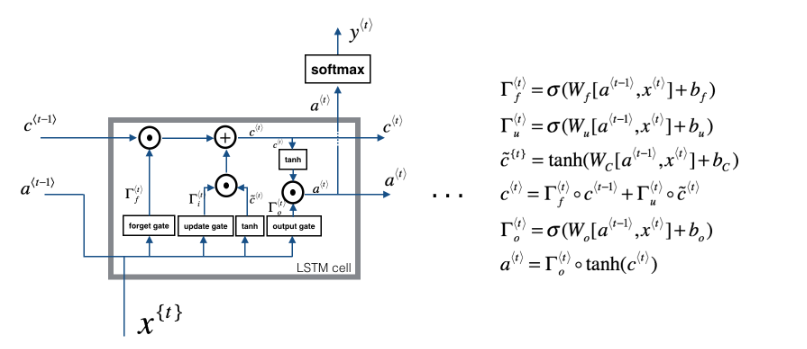
3.1 - LSTM cell
**Instructions:**

1.Concatenate $a^{\langle t-1 \rangle}$ and $x^{\langle t \rangle}$ in a single matrix: $concat = \begin{bmatrix} a^{\langle t-1 \rangle} \\ x^{\langle t \rangle} \end{bmatrix}$  
2.Compute all the formulas 1-6. You can use sigmoid() (provided) and  np.tanh().  
3.Compute the prediction $y^{\langle t \rangle}$. You can use softmax() (provided).

In [19]:
def lstm_cell_forward(xt, a_prev, c_prev, parameters):
    """
    Implement a single forward step of the LSTM-cell as described in Figure (4)

    Arguments:
    xt -- your input data at timestep "t", numpy array of shape (n_x, m).
    a_prev -- Hidden state at timestep "t-1", numpy array of shape (n_a, m)
    c_prev -- Memory state at timestep "t-1", numpy array of shape (n_a, m)
    parameters -- python dictionary containing:
                        Wf -- Weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        bf -- Bias of the forget gate, numpy array of shape (n_a, 1)
                        Wi -- Weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        bi -- Bias of the update gate, numpy array of shape (n_a, 1)
                        Wc -- Weight matrix of the first "tanh", numpy array of shape (n_a, n_a + n_x)
                        bc --  Bias of the first "tanh", numpy array of shape (n_a, 1)
                        Wo -- Weight matrix of the output gate, numpy array of shape (n_a, n_a + n_x)
                        bo --  Bias of the output gate, numpy array of shape (n_a, 1)
                        Wy -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
                        
    Returns:
    a_next -- next hidden state, of shape (n_a, m)
    c_next -- next memory state, of shape (n_a, m)
    yt_pred -- prediction at timestep "t", numpy array of shape (n_y, m)
    cache -- tuple of values needed for the backward pass, contains (a_next, c_next, a_prev, c_prev, xt, parameters)
    
    Note: ft/it/ot stand for the forget/update/output gates, cct stands for the candidate value (c tilde),
          c stands for the memory value
    """
   # Retrieve parameters from "parameters"
    Wf = parameters["Wf"]
    bf = parameters["bf"]
    Wi = parameters["Wi"]
    bi = parameters["bi"]
    Wc = parameters["Wc"]
    bc = parameters["bc"]
    Wo = parameters["Wo"]
    bo = parameters["bo"]
    Wy = parameters["Wy"]
    by = parameters["by"]
    # Retrieve dimensions from shapes of xt and Wy
    n_x, m = xt.shape
    n_y, n_a = Wy.shape
    
    ### START CODE HERE ###
    # Concatenate a_prev and xt (≈3 lines)
    concat = np.zeros((n_a+n_x, m))
    concat[:n_a,:] = a_prev
    concat[n_a:,:] = xt
    
    # Compute values for ft, it, cct, c_next, ot, a_next using the formulas given figure (4) (≈6 lines)
    ft = sigmoid(np.dot(Wf,concat)+bf)
    it = sigmoid(np.dot(Wi, concat) + bi)
    cct = np.tanh(np.dot(Wc, concat) + bc)
    c_next = ft * c_prev + it * cct 
    ot = sigmoid(np.dot(Wo, concat) + bo)
    a_next = ot * np.tanh(c_next)
    # Compute prediction of the LSTM cell (≈1 line)
    yt_pred = softmax(np.dot(Wy, a_next) + by)
    
    # store values needed for backward propagation in cache
    cache = (a_next, c_next, a_prev, c_prev, ft, it, cct, ot, xt, parameters)
    
    return a_next, c_next, yt_pred, cache
    

In [20]:
np.random.seed(1)
xt = np.random.randn(3,10)
a_prev = np.random.randn(5,10)
c_prev = np.random.randn(5,10)
Wf = np.random.randn(5, 5+3)
bf = np.random.randn(5,1)
Wi = np.random.randn(5, 5+3)
bi = np.random.randn(5,1)
Wo = np.random.randn(5, 5+3)
bo = np.random.randn(5,1)
Wc = np.random.randn(5, 5+3)
bc = np.random.randn(5,1)
Wy = np.random.randn(2,5)
by = np.random.randn(2,1)

parameters = {"Wf": Wf, "Wi": Wi, "Wo": Wo, "Wc": Wc, "Wy": Wy, "bf": bf, "bi": bi, "bo": bo, "bc": bc, "by": by}

a_next, c_next, yt, cache = lstm_cell_forward(xt, a_prev, c_prev, parameters)
print("a_next[4] = ", a_next[4])
print("a_next.shape = ", c_next.shape)
print("c_next[2] = ", c_next[2])
print("c_next.shape = ", c_next.shape)
print("yt[1] =", yt[1])
print("yt.shape = ", yt.shape)
print("cache[1][3] =", cache[1][3])
print("len(cache) = ", len(cache))

a_next[4] =  [-0.66408471  0.0036921   0.02088357  0.22834167 -0.85575339  0.00138482
  0.76566531  0.34631421 -0.00215674  0.43827275]
a_next.shape =  (5, 10)
c_next[2] =  [ 0.63267805  1.00570849  0.35504474  0.20690913 -1.64566718  0.11832942
  0.76449811 -0.0981561  -0.74348425 -0.26810932]
c_next.shape =  (5, 10)
yt[1] = [0.79913913 0.15986619 0.22412122 0.15606108 0.97057211 0.31146381
 0.00943007 0.12666353 0.39380172 0.07828381]
yt.shape =  (2, 10)
cache[1][3] = [-0.16263996  1.03729328  0.72938082 -0.54101719  0.02752074 -0.30821874
  0.07651101 -1.03752894  1.41219977 -0.37647422]
len(cache) =  10


3.2 - Forward pass for LSTM
实现整个网络的前向传播过程
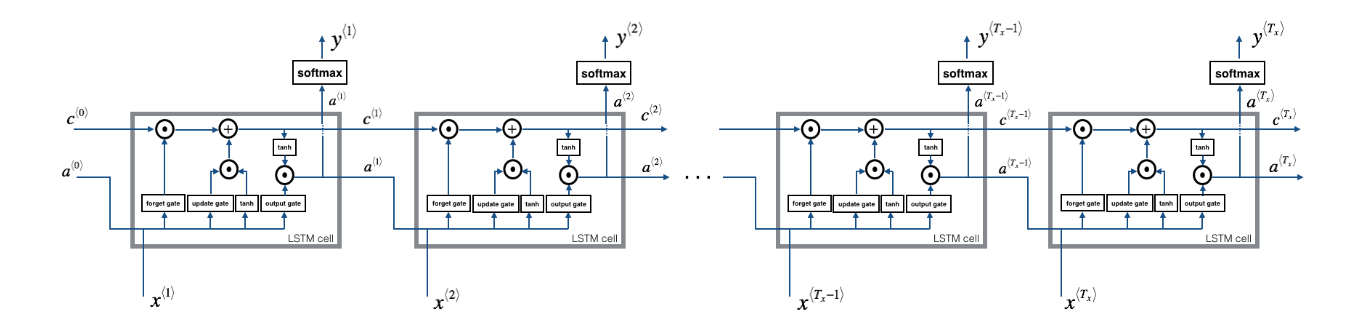

Note:$c^{<0>}$初始化为0

In [36]:
def lstm_forward(x, a0, parameters):
    """
    Implement the forward propagation of the recurrent neural network using an LSTM-cell described in Figure (3).

    Arguments:
    x -- Input data for every time-step, of shape (n_x, m, T_x).
    a0 -- Initial hidden state, of shape (n_a, m)
    parameters -- python dictionary containing:
                        Wf -- Weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        bf -- Bias of the forget gate, numpy array of shape (n_a, 1)
                        Wi -- Weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        bi -- Bias of the update gate, numpy array of shape (n_a, 1)
                        Wc -- Weight matrix of the first "tanh", numpy array of shape (n_a, n_a + n_x)
                        bc -- Bias of the first "tanh", numpy array of shape (n_a, 1)
                        Wo -- Weight matrix of the output gate, numpy array of shape (n_a, n_a + n_x)
                        bo -- Bias of the output gate, numpy array of shape (n_a, 1)
                        Wy -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
                        
    Returns:
    a -- Hidden states for every time-step, numpy array of shape (n_a, m, T_x)
    y -- Predictions for every time-step, numpy array of shape (n_y, m, T_x)
    caches -- tuple of values needed for the backward pass, contains (list of all the caches, x)
    """
    # Initialize "caches", which will track the list of all the caches
    caches = []
    # Retrieve dimensions from shapes of x and Wy (≈2 lines)
    n_x,m,t_x = x.shape
    n_y, n_a = parameters['Wy'].shape
    
    # initialize "a", "c" and "y" with zeros (≈3 lines)
    a = np.zeros((n_a, m, t_x))
    c = a
    y = np.zeros((n_y, m, t_x))
    
    # Initialize a_next and c_next (≈2 lines)
    a_next = a0
    c_next = np.zeros(a_next.shape)
    
    # loop over all time-steps
    for t in range(t_x):
        a_next, c_next, yt, cache = lstm_cell_forward(x[:,:,t],a_next,c_next,parameters)
        # Save the value of the new "next" hidden state in a (≈1 line)
        a[:,:,t] = a_next
        # Save the value of the prediction in y (≈1 line)
        y[:,:,t] = yt
        # Save the value of the next cell state (≈1 line)
        c[:,:,t]  = c_next
        # Append the cache into caches (≈1 line)
        caches.append(cache)
        
    caches = (caches,x)
        
    return a,y,c,caches

In [37]:
np.random.seed(1)
x = np.random.randn(3,10,7)
a0 = np.random.randn(5,10)
Wf = np.random.randn(5, 5+3)
bf = np.random.randn(5,1)
Wi = np.random.randn(5, 5+3)
bi = np.random.randn(5,1)
Wo = np.random.randn(5, 5+3)
bo = np.random.randn(5,1)
Wc = np.random.randn(5, 5+3)
bc = np.random.randn(5,1)
Wy = np.random.randn(2,5)
by = np.random.randn(2,1)

parameters = {"Wf": Wf, "Wi": Wi, "Wo": Wo, "Wc": Wc, "Wy": Wy, "bf": bf, "bi": bi, "bo": bo, "bc": bc, "by": by}

a, y, c, caches = lstm_forward(x, a0, parameters)
print("a[4][3][6] = ", a[4][3][6])
print("a.shape = ", a.shape)
print("y[1][4][3] =", y[1][4][3])
print("y.shape = ", y.shape)
print("caches[1][1[1]] =", caches[1][1][1])
print("c[1][2][1]", c[1][2][1])
print("len(caches) = ", len(caches))

a[4][3][6] =  0.7316245102699646
a.shape =  (5, 10, 7)
y[1][4][3] = 0.9508734618501101
y.shape =  (2, 10, 7)
caches[1][1[1]] = [ 0.82797464  0.23009474  0.76201118 -0.22232814 -0.20075807  0.18656139
  0.41005165]
c[1][2][1] -0.8555449167181981
len(caches) =  2


# 4. LSTM backward pass
* 4.1 - one step backward
[手推公式](https://blog.csdn.net/qq_29762941/article/details/89294252)  
需要注意的是dct和act的偏导都是从两部分传导进来的（一定要注意！！）给定的$da_next$包含所有部分的梯度，而$dc_next$则仅包含$c^{<t>}$传导进来的梯度。  

* gate 求偏导  
对原先的公式做了一些改动。。。

$$d \Gamma_o^{\langle t \rangle} = da_{next}*\tanh(c_{next}) * \Gamma_o^{\langle t \rangle}*(1-\Gamma_o^{\langle t \rangle})\tag{7}$$   

$$d\tilde c^{\langle t \rangle} = [dc_{next}*\Gamma_i^{\langle t \rangle}+ \Gamma_o^{\langle t \rangle} (1-\tanh(c_{next})^2] * \Gamma_i^{\langle t \rangle} * da_{next}) * (1-\tanh(\tilde c)^2) \tag{8}$$  

$$d\Gamma_u^{\langle t \rangle} = [dc_{next}*\tilde c^{\langle t \rangle} + \Gamma_o^{\langle t \rangle} (1-\tanh(c_{next})^2) * \tilde c^{\langle t \rangle} * da_{next}]*\Gamma_u^{\langle t \rangle}*(1-\Gamma_u^{\langle t \rangle})\tag{9}$$  

$$d\Gamma_f^{\langle t \rangle} = [dc_{next}* c_{prev} + \Gamma_o^{\langle t \rangle} (1-\tanh(c_{next})^2) * c_{prev} * da_{next}]*\Gamma_f^{\langle t \rangle}*(1-\Gamma_f^{\langle t \rangle})\tag{10}$$

* parameter 求偏导
$$ dW_f = d\Gamma_f^{\langle t \rangle} * \begin{pmatrix} a_{prev} \\ x_t\end{pmatrix}^T \tag{11} $$  
$$ dW_u = d\Gamma_u^{\langle t \rangle} * \begin{pmatrix} a_{prev} \\ x_t\end{pmatrix}^T \tag{12} $$  
$$ dW_c = d\tilde c^{\langle t \rangle} * \begin{pmatrix} a_{prev} \\ x_t\end{pmatrix}^T \tag{13} $$  
$$ dW_o = d\Gamma_o^{\langle t \rangle} * \begin{pmatrix} a_{prev} \\ x_t\end{pmatrix}^T \tag{14}$$  

计算 $db_f, db_u, db_c, db_o$时只需要对$d\Gamma_f^{\langle t \rangle}, d\Gamma_u^{\langle t \rangle}, d\tilde c^{\langle t \rangle}, d\Gamma_o^{\langle t \rangle}$在axis=1的维度求偏导。  

$$ da_{prev} = W_f^T*d\Gamma_f^{\langle t \rangle} + W_u^T * d\Gamma_u^{\langle t \rangle}+ W_c^T * d\tilde c^{\langle t \rangle} + W_o^T * d\Gamma_o^{\langle t \rangle} \tag{15}$$  
此处 $W_f = W_f[:,:n_a]$  

$$ dc_{prev} = dc_{next}\Gamma_f^{\langle t \rangle} + \Gamma_o^{\langle t \rangle} * (1- \tanh(c_{next})^2)*\Gamma_f^{\langle t \rangle}*da_{next} \tag{16}$$   

$$ dx^{\langle t \rangle} = W_f^T*d\Gamma_f^{\langle t \rangle} + W_u^T * d\Gamma_u^{\langle t \rangle}+ W_c^T * d\tilde c_t + W_o^T * d\Gamma_o^{\langle t \rangle}\tag{17} $$
此处 $W_f = W_f[:,n_a:]$ 

In [38]:
def lstm_cell_backward(da_next, dc_next, cache):
    """
    Implement the backward pass for the LSTM-cell (single time-step).

    Arguments:
    da_next -- Gradients of next hidden state, of shape (n_a, m)
    dc_next -- Gradients of next cell state, of shape (n_a, m)
    cache -- cache storing information from the forward pass

    Returns:
    gradients -- python dictionary containing:
                        dxt -- Gradient of input data at time-step t, of shape (n_x, m)
                        da_prev -- Gradient w.r.t. the previous hidden state, numpy array of shape (n_a, m)
                        dc_prev -- Gradient w.r.t. the previous memory state, of shape (n_a, m, T_x)
                        dWf -- Gradient w.r.t. the weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        dWi -- Gradient w.r.t. the weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        dWc -- Gradient w.r.t. the weight matrix of the memory gate, numpy array of shape (n_a, n_a + n_x)
                        dWo -- Gradient w.r.t. the weight matrix of the output gate, numpy array of shape (n_a, n_a + n_x)
                        dbf -- Gradient w.r.t. biases of the forget gate, of shape (n_a, 1)
                        dbi -- Gradient w.r.t. biases of the update gate, of shape (n_a, 1)
                        dbc -- Gradient w.r.t. biases of the memory gate, of shape (n_a, 1)
                        dbo -- Gradient w.r.t. biases of the output gate, of shape (n_a, 1)
    """

    # Retrieve information from "cache"
    (a_next, c_next, a_prev, c_prev, ft, it, cct, ot, xt, parameters) = cache
    
    ### START CODE HERE ###
    # Retrieve dimensions from xt's and a_next's shape (≈2 lines)
    n_x, m = xt.shape
    n_a, m = a_next.shape
    
    # Compute gates related derivatives, you can find their values can be found by looking carefully at equations (7) to (10) (≈4 lines)
    dot = da_next * np.tanh(c_next) * ot * (1 - ot)
    dcct = (dc_next * it + ot * (1 - np.square(np.tanh(c_next))) * it * da_next) * (1 - np.square(cct))
    dit = (dc_next * cct + ot * (1 - np.square(np.tanh(c_next))) * cct * da_next) * it * (1 - it)
    dft = (dc_next * c_prev + ot *(1 - np.square(np.tanh(c_next))) * c_prev * da_next) * ft * (1 - ft)
    
    # compute parameters related derivatives.
    concat = np.concatenate((a_prev, xt),axis=0)
   
    dWf = np.dot(dft,concat.T)
    dWi = np.dot(dit, concat.T)
    dWc = np.dot(dcct, concat.T)
    dWo = np.dot(dot, concat.T)
    dbf = np.sum(dft, axis=1 ,keepdims = True)
    dbi = np.sum(dit, axis=1, keepdims = True)
    dbc = np.sum(dcct, axis=1,  keepdims = True)
    dbo = np.sum(dot, axis=1, keepdims = True)
    
    # Compute derivatives w.r.t previous hidden state, previous memory state and input. 
    da_prev = np.dot(parameters['Wf'][:, :n_a].T, dft) + np.dot(parameters['Wi'][:, :n_a].T, dit) + np.dot(parameters['Wc'][:, :n_a].T, dcct) + np.dot(parameters['Wo'][:, :n_a].T, dot)
    dc_prev = dc_next * ft + ot * (1 - np.square(np.tanh(c_next))) * ft * da_next
    dxt =  np.dot(parameters['Wf'][:, n_a:].T, dft) + np.dot(parameters['Wi'][:, n_a:].T, dit) + np.dot(parameters['Wc'][:, n_a:].T, dcct) + np.dot(parameters['Wo'][:, n_a:].T, dot)
    
     # Save gradients in dictionary
    gradients = {"dxt": dxt, "da_prev": da_prev, "dc_prev": dc_prev, "dWf": dWf,"dbf": dbf, "dWi": dWi,"dbi": dbi,
                "dWc": dWc,"dbc": dbc, "dWo": dWo,"dbo": dbo}
    return gradients

In [39]:
np.random.seed(1)
xt = np.random.randn(3,10)
a_prev = np.random.randn(5,10)
c_prev = np.random.randn(5,10)
Wf = np.random.randn(5, 5+3)
bf = np.random.randn(5,1)
Wi = np.random.randn(5, 5+3)
bi = np.random.randn(5,1)
Wo = np.random.randn(5, 5+3)
bo = np.random.randn(5,1)
Wc = np.random.randn(5, 5+3)
bc = np.random.randn(5,1)
Wy = np.random.randn(2,5)
by = np.random.randn(2,1)

parameters = {"Wf": Wf, "Wi": Wi, "Wo": Wo, "Wc": Wc, "Wy": Wy, "bf": bf, "bi": bi, "bo": bo, "bc": bc, "by": by}

a_next, c_next, yt, cache = lstm_cell_forward(xt, a_prev, c_prev, parameters)

da_next = np.random.randn(5,10)
dc_next = np.random.randn(5,10)
gradients = lstm_cell_backward(da_next, dc_next, cache)

print("gradients[\"dxt\"][1][2] =", gradients["dxt"][1][2])
print("gradients[\"dxt\"].shape =", gradients["dxt"].shape)
print("gradients[\"da_prev\"][2][3] =", gradients["da_prev"][2][3])
print("gradients[\"da_prev\"].shape =", gradients["da_prev"].shape)
print("gradients[\"dc_prev\"][2][3] =", gradients["dc_prev"][2][3])
print("gradients[\"dc_prev\"].shape =", gradients["dc_prev"].shape)
print("gradients[\"dWf\"][3][1] =", gradients["dWf"][3][1])
print("gradients[\"dWf\"].shape =", gradients["dWf"].shape)
print("gradients[\"dWi\"][1][2] =", gradients["dWi"][1][2])
print("gradients[\"dWi\"].shape =", gradients["dWi"].shape)
print("gradients[\"dWc\"][3][1] =", gradients["dWc"][3][1])
print("gradients[\"dWc\"].shape =", gradients["dWc"].shape)
print("gradients[\"dWo\"][1][2] =", gradients["dWo"][1][2])
print("gradients[\"dWo\"].shape =", gradients["dWo"].shape)
print("gradients[\"dbf\"][4] =", gradients["dbf"][4])
print("gradients[\"dbf\"].shape =", gradients["dbf"].shape)
print("gradients[\"dbi\"][4] =", gradients["dbi"][4])
print("gradients[\"dbi\"].shape =", gradients["dbi"].shape)
print("gradients[\"dbc\"][4] =", gradients["dbc"][4])
print("gradients[\"dbc\"].shape =", gradients["dbc"].shape)
print("gradients[\"dbo\"][4] =", gradients["dbo"][4])
print("gradients[\"dbo\"].shape =", gradients["dbo"].shape)

gradients["dxt"][1][2] = 3.2305591151091875
gradients["dxt"].shape = (3, 10)
gradients["da_prev"][2][3] = -0.06396214197109236
gradients["da_prev"].shape = (5, 10)
gradients["dc_prev"][2][3] = 0.7975220387970015
gradients["dc_prev"].shape = (5, 10)
gradients["dWf"][3][1] = -0.1479548381644968
gradients["dWf"].shape = (5, 8)
gradients["dWi"][1][2] = 1.0574980552259903
gradients["dWi"].shape = (5, 8)
gradients["dWc"][3][1] = 2.3045621636876668
gradients["dWc"].shape = (5, 8)
gradients["dWo"][1][2] = 0.3313115952892109
gradients["dWo"].shape = (5, 8)
gradients["dbf"][4] = [0.18864637]
gradients["dbf"].shape = (5, 1)
gradients["dbi"][4] = [-0.40142491]
gradients["dbi"].shape = (5, 1)
gradients["dbc"][4] = [0.25587763]
gradients["dbc"].shape = (5, 1)
gradients["dbo"][4] = [0.13893342]
gradients["dbo"].shape = (5, 1)


将lstm_backward 函数完整的传输一遍  
注：dxt不做更新，只作保存


In [43]:
def lstm_backward(da, caches):
    
    """
    Implement the backward pass for the RNN with LSTM-cell (over a whole sequence).

    Arguments:
    da -- Gradients w.r.t the hidden states, numpy-array of shape (n_a, m, T_x)
    dc -- Gradients w.r.t the memory states, numpy-array of shape (n_a, m, T_x)
    caches -- cache storing information from the forward pass (lstm_forward)

    Returns:
    gradients -- python dictionary containing:
                        dx -- Gradient of inputs, of shape (n_x, m, T_x)
                        da0 -- Gradient w.r.t. the previous hidden state, numpy array of shape (n_a, m)
                        dWf -- Gradient w.r.t. the weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        dWi -- Gradient w.r.t. the weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        dWc -- Gradient w.r.t. the weight matrix of the memory gate, numpy array of shape (n_a, n_a + n_x)
                        dWo -- Gradient w.r.t. the weight matrix of the save gate, numpy array of shape (n_a, n_a + n_x)
                        dbf -- Gradient w.r.t. biases of the forget gate, of shape (n_a, 1)
                        dbi -- Gradient w.r.t. biases of the update gate, of shape (n_a, 1)
                        dbc -- Gradient w.r.t. biases of the memory gate, of shape (n_a, 1)
                        dbo -- Gradient w.r.t. biases of the save gate, of shape (n_a, 1)
    """

    # Retrieve values from the first cache (t=1) of caches.
    (caches, x) = caches
    (a1, c1, a0, c0, f1, i1, cc1, o1, x1, parameters) = caches[0]
    
    ### START CODE HERE ###
    # Retrieve dimensions from da's and x1's shapes (≈2 lines)
    n_a, m, T_x = da.shape
    n_x, m = x1.shape
    
    # initialize the gradients with the right sizes (≈12 lines)
    dx = np.zeros((n_x, m, T_x))
    da0 = np.zeros((n_a, m))
    dc_prevt = np.zeros(da0.shape)
#    da_prevt = np.zeros(da0.shape)
    dWf = np.zeros((n_a, n_a + n_x))
    dWi = np.zeros(dWf.shape)
    dWc = np.zeros(dWf.shape)
    dWo = np.zeros(dWf.shape)
    dbf = np.zeros((n_a, 1))
    dbi = np.zeros(dbf.shape)
    dbc = np.zeros(dbf.shape)
    dbo = np.zeros(dbf.shape)
    
    # loop back over the whole sequence
    for t in reversed(range(T_x)):
        # Compute all gradients using lstm_cell_backward
        gradients = lstm_cell_backward(da[:, :, t], dc_prevt, caches[t])# 这里的输入为什么不是（da[:,:,t]+da_prevt,dc_prev）
        
        dc_prevt = gradients['dc_prevt']
        da_prevt = gradients['da_prevt']
        # Store or add the gradient to the parameters' previous step's gradient
        dx[:,:,t] = gradients["dxt"]
        dWf += gradients["dWf"]
        dWi += gradients["dWi"]
        dWc += gradients["dWc"]
        dWo += gradients["dWo"]
        dbf += gradients["dbf"]
        dbi += gradients["dbi"]
        dbc += gradients["dbc"]
        dbo += gradients["dbo"]
    # Set the first activation's gradient to the backpropagated gradient da_prev.
    da0 = gradients["da_prev"]
    
    ### END CODE HERE ###

    # Store the gradients in a python dictionary
    gradients = {"dx": dx, "da0": da0, "dWf": dWf,"dbf": dbf, "dWi": dWi,"dbi": dbi,
                "dWc": dWc,"dbc": dbc, "dWo": dWo,"dbo": dbo}
    
    return gradients

In [44]:
np.random.seed(1)
x = np.random.randn(3,10,7)
a0 = np.random.randn(5,10)
Wf = np.random.randn(5, 5+3)
bf = np.random.randn(5,1)
Wi = np.random.randn(5, 5+3)
bi = np.random.randn(5,1)
Wo = np.random.randn(5, 5+3)
bo = np.random.randn(5,1)
Wc = np.random.randn(5, 5+3)
bc = np.random.randn(5,1)

parameters = {"Wf": Wf, "Wi": Wi, "Wo": Wo, "Wc": Wc, "Wy": Wy, "bf": bf, "bi": bi, "bo": bo, "bc": bc, "by": by}

a, y, c, caches = lstm_forward(x, a0, parameters)

da = np.random.randn(5, 10, 4)
gradients = lstm_backward(da, caches)

print("gradients[\"dx\"][1][2] =", gradients["dx"][1][2])
print("gradients[\"dx\"].shape =", gradients["dx"].shape)
print("gradients[\"da0\"][2][3] =", gradients["da0"][2][3])
print("gradients[\"da0\"].shape =", gradients["da0"].shape)
print("gradients[\"dWf\"][3][1] =", gradients["dWf"][3][1])
print("gradients[\"dWf\"].shape =", gradients["dWf"].shape)
print("gradients[\"dWi\"][1][2] =", gradients["dWi"][1][2])
print("gradients[\"dWi\"].shape =", gradients["dWi"].shape)
print("gradients[\"dWc\"][3][1] =", gradients["dWc"][3][1])
print("gradients[\"dWc\"].shape =", gradients["dWc"].shape)
print("gradients[\"dWo\"][1][2] =", gradients["dWo"][1][2])
print("gradients[\"dWo\"].shape =", gradients["dWo"].shape)
print("gradients[\"dbf\"][4] =", gradients["dbf"][4])
print("gradients[\"dbf\"].shape =", gradients["dbf"].shape)
print("gradients[\"dbi\"][4] =", gradients["dbi"][4])
print("gradients[\"dbi\"].shape =", gradients["dbi"].shape)
print("gradients[\"dbc\"][4] =", gradients["dbc"][4])
print("gradients[\"dbc\"].shape =", gradients["dbc"].shape)
print("gradients[\"dbo\"][4] =", gradients["dbo"][4])
print("gradients[\"dbo\"].shape =", gradients["dbo"].shape)

gradients["dx"][1][2] = [-0.00173313  0.08287442 -0.30545663 -0.43281115]
gradients["dx"].shape = (3, 10, 4)
gradients["da0"][2][3] = -0.09591150195400468
gradients["da0"].shape = (5, 10)
gradients["dWf"][3][1] = -0.06981985612744009
gradients["dWf"].shape = (5, 8)
gradients["dWi"][1][2] = 0.10237182024854771
gradients["dWi"].shape = (5, 8)
gradients["dWc"][3][1] = -0.062498379492745226
gradients["dWc"].shape = (5, 8)
gradients["dWo"][1][2] = 0.04843891314443012
gradients["dWo"].shape = (5, 8)
gradients["dbf"][4] = [-0.0565788]
gradients["dbf"].shape = (5, 1)
gradients["dbi"][4] = [-0.15399065]
gradients["dbi"].shape = (5, 1)
gradients["dbc"][4] = [-0.29691142]
gradients["dbc"].shape = (5, 1)
gradients["dbo"][4] = [-0.29798344]
gradients["dbo"].shape = (5, 1)
